In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import neuralprocesses.torch as nps

dtype = torch.float32

In [14]:
path = "/scratches/cblgpu07/em626/neuralprocesses/_experiments/antarctica/convcnp/unet/loglik/model-last.torch"
model = nps.construct_convgnp(
    dim_x=2,
    dim_y=2,
    dim_yc=(1,) * 2,
    dim_yt=2,
    points_per_unit=512,
    margin=0.2,
    likelihood="het",
    unet_channels=(8, 16, 32, 64, 128, 256),
    unet_strides=(1,) + 5 * (2,),
    encoder_scales=2/512,
)

model.load_state_dict(torch.load(path)["weights"])
model.eval()

print("Model loaded")

generator = nps.AntarcticaGenerator(
    dtype=dtype,
    root_dir="/scratches/cblgpu07/em626/neuralprocesses/antarctica-data",
    seed=0,
    num_tasks=10**2,
    batch_size=8,
    subset="cv",
)

batch = generator.generate_batch()

Model loaded


In [15]:
batch["xt"][0][0].shape, batch["xt"][0][1], batch["xt"][1][0].shape, batch["xt"][1][1]

(torch.Size([8, 2, 0]), 0, torch.Size([8, 2, 7]), 1)

In [16]:
grid = torch.stack(
    torch.meshgrid(
        torch.linspace(-1., 1., 100, dtype=dtype),
        torch.linspace(-1., 1., 100, dtype=dtype),
    ),
    axis=-1,
)

grid = grid.reshape(-1, 2)
grid = torch.transpose(grid, 1, 0)
grid = torch.stack(8*[grid], axis=0)

In [17]:
batch["xt"][0][0].shape, batch["xt"][1][0].shape

(torch.Size([8, 2, 0]), torch.Size([8, 2, 7]))

In [18]:
grid_target = nps.AggregateInput(*(
    (grid[:, :, :0], 0),
    (grid, 1),
))

In [19]:
mean, var, samples, _ = nps.predict(
    model,
    batch["contexts"],
    grid_target,
)

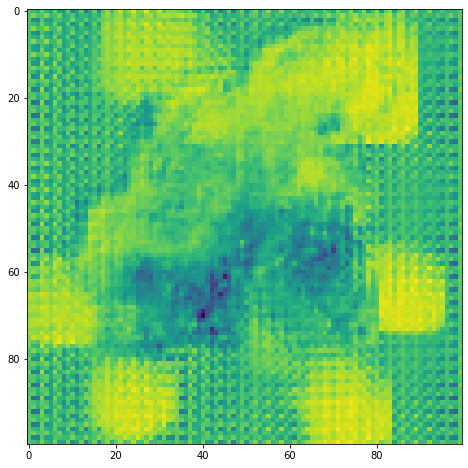

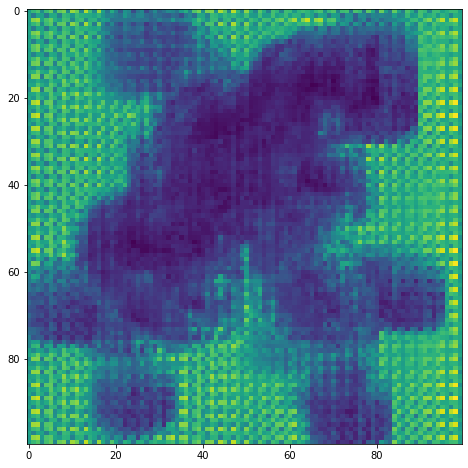

In [22]:
plt.figure(figsize=(8, 8))
plt.imshow(mean.elements[1].reshape(8, 100, 100).cpu().detach().numpy()[0])
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(var.elements[1].reshape(8, 100, 100).cpu().detach().numpy()[0]**0.5)
plt.show()

In [11]:
batch["contexts"][0][0].shape

torch.Size([8, 2, 18])